# Bike Sharing Demand

## CRISP-DM Approach

CRISP-DM stands for Cross-Industry Standard Process for Data Mining and describes a structured approach to understanding, preparing, modeling and evaluating data. This process includes the following steps:

1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation
6. Deployment

Deployment is not relevant for this type of project, as I won't be deploying my model to a web server. However, my results will be summarized in a blog post on Medium (https://medium.com/@julia.nikulski).

### 1. Business Understanding

### 2. Data Understanding

The data set is similar to the bike sharing dataset provided by the [UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). However, the aforementioned dataset only contains data for 2011 and 2012. It was originally created by Fanaee-T and Gama (2013) in their study ["Event labeling combining ensemble detectors and background knowledge"](https://link.springer.com/article/10.1007/s13748-013-0040-3). 

To have a larger dataset, I collected the following data from the following sources for the time period of January 1, 2011 until December 31, 2018:
* The bike demand data comes from [Capital Bike Share](http://capitalbikeshare.com/system-data)
* The weather data was taken from [NOAA's National Climatic Data Center](https://www.ncdc.noaa.gov/cdo-web/search)
* The holiday data is from the [DC Department of Human Resources](http://dchr.dc.gov/page/holiday-schedule). 

The dataset uses data from the bike sharing stations of Capital Bike Share in Washington, D.C., USA. The weather data and holiday data refer to the same location.


In [63]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal, pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_validate, TimeSeriesSplit
from datetime import datetime


import seaborn as sb
import matplotlib.pyplot as plt 

%matplotlib inline


#### 2.1. Loading the data and visualizing and describing it

In [64]:
# read in bike sharing dataset
bike_df = pd.read_csv('bike_sharing_dataset.csv')
bike_df.head()


,date,temp_avg,temp_min,temp_max,temp_observ,precip,wind,wt_fog,wt_heavy_fog,wt_thunder,...,wt_freeze_rain,wt_snow,wt_ground_fog,wt_ice_fog,wt_freeze_drizzle,wt_unknown,casual,registered,total_cust,holiday
0,2011-01-01,NaN,-1.566667,11.973333,2.772727,0.069333,2.575,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,330.0,629.0,959.0,NaN
1,2011-01-02,NaN,0.880000,13.806667,7.327273,1.037349,3.925,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,130.0,651.0,781.0,NaN
2,2011-01-03,NaN,-3.442857,7.464286,-3.060000,1.878824,3.625,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,120.0,1181.0,1301.0,NaN
3,2011-01-04,NaN,-5.957143,4.642857,-3.100000,0.000000,1.800,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,107.0,1429.0,1536.0,NaN
4,2011-01-05,NaN,-4.293333,6.113333,-1.772727,0.000000,2.950,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,82.0,1489.0,1571.0,NaN


In [65]:
# print descriptive statistics
bike_df.describe()


,temp_avg,temp_min,temp_max,temp_observ,precip,wind,wt_fog,wt_heavy_fog,wt_thunder,wt_sleet,...,wt_freeze_rain,wt_snow,wt_ground_fog,wt_ice_fog,wt_freeze_drizzle,wt_unknown,casual,registered,total_cust,holiday
count,2101.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,1503.0,208.0,694.0,129.0,...,5.0,84.0,36.0,10.0,4.0,1.0,2918.000000,2918.000000,2918.000000,89.0
mean,14.419007,8.506468,19.015689,11.069243,3.435734,3.162898,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1679.776217,6046.297121,7726.073338,1.0
std,9.556401,9.473941,9.835524,9.481232,8.183658,1.379582,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,1560.762932,2756.888032,3745.220092,0.0
min,-12.100000,-16.993750,-7.980000,-15.658333,0.000000,0.375000,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,2.000000,19.000000,21.000000,1.0
25%,6.566667,0.516538,11.081562,3.013068,0.005510,2.200000,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,512.250000,3839.250000,4628.500000,1.0
50%,15.433333,8.504911,19.992857,11.619091,0.271504,2.900000,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1220.500000,5964.000000,7442.500000,1.0
75%,23.066667,17.338393,27.874583,19.767083,2.885381,3.875000,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,2357.250000,8187.500000,10849.500000,1.0
max,31.733333,26.206250,37.850000,28.666667,118.789796,12.750000,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,10173.000000,15419.000000,19113.000000,1.0


In [66]:
# check the datatypes of each variable
bike_df.dtypes


date                  object
temp_avg             float64
temp_min             float64
temp_max             float64
temp_observ          float64
precip               float64
wind                 float64
wt_fog               float64
wt_heavy_fog         float64
wt_thunder           float64
wt_sleet             float64
wt_hail              float64
wt_glaze             float64
wt_haze              float64
wt_drift_snow        float64
wt_high_wind         float64
wt_mist              float64
wt_drizzle           float64
wt_rain              float64
wt_freeze_rain       float64
wt_snow              float64
wt_ground_fog        float64
wt_ice_fog           float64
wt_freeze_drizzle    float64
wt_unknown           float64
casual               float64
registered           float64
total_cust           float64
holiday              float64
dtype: object

In [67]:
bike_df.head()

,date,temp_avg,temp_min,temp_max,temp_observ,precip,wind,wt_fog,wt_heavy_fog,wt_thunder,...,wt_freeze_rain,wt_snow,wt_ground_fog,wt_ice_fog,wt_freeze_drizzle,wt_unknown,casual,registered,total_cust,holiday
0,2011-01-01,NaN,-1.566667,11.973333,2.772727,0.069333,2.575,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,330.0,629.0,959.0,NaN
1,2011-01-02,NaN,0.880000,13.806667,7.327273,1.037349,3.925,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,130.0,651.0,781.0,NaN
2,2011-01-03,NaN,-3.442857,7.464286,-3.060000,1.878824,3.625,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,120.0,1181.0,1301.0,NaN
3,2011-01-04,NaN,-5.957143,4.642857,-3.100000,0.000000,1.800,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,107.0,1429.0,1536.0,NaN
4,2011-01-05,NaN,-4.293333,6.113333,-1.772727,0.000000,2.950,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,82.0,1489.0,1571.0,NaN


Based on the source repository of the data set, these are the meanings of each variable:
- date: date
- temp_avg: average temperature in Celcius
- temp_min: minimum temperature in Celcius
- temp_max: maximum temperature in Celcius
- temp_observ: temperature at time of observation
- precip: precipitation in mm 
- wind: average windspeed
- wt: weather types
    - fog: fog, ice fog, or freezing fog (may include heavy fog)
    - heavy_fog: heavy fog or heaving freezing fog (not always distinguished from fog)
    - thunder: thunder
    - sleet: ice pellets, sleet, snow pellets, or small hail
    - hail: hail (may include small hail)
    - glaze: glaze or rime
    - haze: smoke or haze
    - drift_snow: blowing or drifting snow 
    - high_wind: high or damaging winds
    - mist: mist
    - drizzle: drizzle
    - rain: rain (may include freezing rain, drizzle, and freezing drizzle)
    - freeze_rain: freezing rain
    - snow: snow, snow pellets, snow grains, or ice crystals
    - ground_fog: ground fog
    - ice_fog: ice for or freezing fog
    - freeze_drizzle: freezing drizzle
    - unknown: unknown source of precipitation
- casual: count of casual users
- registered: count of registered users
- total_cust: count of total rental bikes including both casual and registered
- holiday: holiday in Washington D.C.


##### Checking for and dealing with missing values

In [68]:
# Check for missing values
bike_df.isnull().sum()


date                    0
temp_avg              821
temp_min                0
temp_max                0
temp_observ             0
precip                  0
wind                    0
wt_fog               1419
wt_heavy_fog         2714
wt_thunder           2228
wt_sleet             2793
wt_hail              2872
wt_glaze             2769
wt_haze              2217
wt_drift_snow        2915
wt_high_wind         2664
wt_mist              2551
wt_drizzle           2794
wt_rain              2516
wt_freeze_rain       2917
wt_snow              2838
wt_ground_fog        2886
wt_ice_fog           2912
wt_freeze_drizzle    2918
wt_unknown           2921
casual                  4
registered              4
total_cust              4
holiday              2833
dtype: int64

The feature **temp_avg** is missing 821 values. I will use the temp_min, temp_max and temp_observ features to estimate the missing temp_avg values. There are also 4 values missing for **casual, registered and total_cust features** and the target, respectively. I will check why these are missing and exclude those observations because if the target variable is missing, I cannot estimate it. 

The **holiday** feature has NAs but these should actually 0s, which I will convert. The **wt_** features also have NAs where 0s should be which I will insert.


In [69]:
# fill NAs with 0 where applicable
wt_feats = [x for x in bike_df.columns if 'wt' in x]
bike_df['holiday'] = bike_df['holiday'].fillna(0)
bike_df[wt_feats] = bike_df[wt_feats].fillna(0)


In [70]:
# check casual, registered and total_cust missing rows
bike_df[bike_df['total_cust'].isna()]


,date,temp_avg,temp_min,temp_max,temp_observ,precip,wind,wt_fog,wt_heavy_fog,wt_thunder,...,wt_freeze_rain,wt_snow,wt_ground_fog,wt_ice_fog,wt_freeze_drizzle,wt_unknown,casual,registered,total_cust,holiday
1848,2016-01-23,-4.366667,-6.128571,-2.392857,-4.688889,42.045946,8.08,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0
1849,2016-01-24,-2.666667,-7.985714,-1.028571,-6.366667,19.339130,3.75,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0
1850,2016-01-25,-5.133333,-11.128571,2.028571,-9.877778,0.000000,1.15,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0
1851,2016-01-26,2.333333,-7.871429,7.471429,3.588889,0.000000,2.85,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0


There seem to be four days where no data was captured for the rented bikes. Because this is a time series, I am not sure whether I can drop these rows or whether I should interpolate the target values for these four days. More research is necessary to determine this.

In [71]:
bike_df['total_cust'][1845:1855]

1845    4321.0
1846    4228.0
1847    2985.0
1848       NaN
1849       NaN
1850       NaN
1851       NaN
1852     528.0
1853    2022.0
1854    2942.0
Name: total_cust, dtype: float64

In [72]:
# assigning rows with missing target label a -1 so that they stay in the model but they are 
# marked is irregular value
bike_df.fillna(value={'total_cust': -1, 'casual': -1, 'registered': -1}, inplace=True)


In [73]:
# which rows have the average temperature missing
bike_df[bike_df['temp_avg'].isna()] # all rows between 0 and 820


,date,temp_avg,temp_min,temp_max,temp_observ,precip,wind,wt_fog,wt_heavy_fog,wt_thunder,...,wt_freeze_rain,wt_snow,wt_ground_fog,wt_ice_fog,wt_freeze_drizzle,wt_unknown,casual,registered,total_cust,holiday
0,2011-01-01,NaN,-1.566667,11.973333,2.772727,0.069333,2.575,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,330.0,629.0,959.0,0.0
1,2011-01-02,NaN,0.880000,13.806667,7.327273,1.037349,3.925,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,130.0,651.0,781.0,0.0
2,2011-01-03,NaN,-3.442857,7.464286,-3.060000,1.878824,3.625,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,120.0,1181.0,1301.0,0.0
3,2011-01-04,NaN,-5.957143,4.642857,-3.100000,0.000000,1.800,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,107.0,1429.0,1536.0,0.0
4,2011-01-05,NaN,-4.293333,6.113333,-1.772727,0.000000,2.950,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,82.0,1489.0,1571.0,0.0
5,2011-01-06,NaN,-4.993333,4.233333,-4.245455,0.000000,1.600,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,88.0,1485.0,1573.0,0.0
6,2011-01-07,NaN,-3.885714,2.857143,-1.570000,0.101205,2.550,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,148.0,1345.0,1493.0,0.0
7,2011-01-08,NaN,-3.980000,0.486667,-2.472727,0.285057,4.575,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,68.0,871.0,939.0,0.0
8,2011-01-09,NaN,-6.293333,0.226667,-6.072727,0.283529,6.425,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,54.0,748.0,802.0,0.0
9,2011-01-10,NaN,-6.238462,0.507692,-5.177778,0.000000,2.975,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,41.0,1257.0,1298.0,0.0


In [74]:
# check what the correlation between the different temperature features and total_cust is
# maybe I could just use one of the other temperature features instead of temp_avg

# correlation between temp_avg and total_cust
# I'm excluding the first 820 rows because they contain missing temp_avg values
print('temp_avg:', pearsonr(bike_df['temp_avg'][821:], bike_df['total_cust'][821:]))

# correlation between temp_min and total_cust
print('temp_min:', pearsonr(bike_df['temp_min'], bike_df['total_cust']))
print('temp_min, without first 820 rows:', pearsonr(bike_df['temp_min'][821:], bike_df['total_cust'][821:]))

# correlation between temp_max and total_cust
print('temp_max:', pearsonr(bike_df['temp_max'], bike_df['total_cust']))
print('temp_max, without first 820 rows:', pearsonr(bike_df['temp_max'][821:], bike_df['total_cust'][821:]))

# correlation between temp_observ and total_cust
print('temp_observ:', pearsonr(bike_df['temp_observ'], bike_df['total_cust']))
print('temp_observ, without first 820 rows:', pearsonr(bike_df['temp_observ'][821:], bike_df['total_cust'][821:]))


temp_avg: (0.7293056313590628, 0.0)
temp_min: (0.5493446655127942, 4.551527730770392e-230)
temp_min, without first 820 rows: (0.672614016123332, 8.360712226124258e-277)
temp_max: (0.5971103034228888, 6.817965444868263e-282)
temp_max, without first 820 rows: (0.7410516946153353, 0.0)
temp_observ: (0.550786439566417, 1.6404856236281734e-231)
temp_observ, without first 820 rows: (0.6807986072994302, 4.0023422329777753e-286)


The above shows that disregarding the first 820 rows leads to the highest correlation between temp_max and total_cust. However, comparing temp_avg with the entire dataset and the respective correlations with total_cust, temp_avg has the highest correlation. I will estimate the missing temp_avg figures and see how the correlation changes and decide how to proceed.

In [75]:
# function to create seasons for dataframe
def seasons(df):
    '''
    Function to create new features for seasons based on months
    Args: df = dataframe
    Returns: df = dataframe
    '''
    # create a season features
    df['season_spring'] = df['date'].apply(lambda x: 1 if '01' in x[5:7] else 1 if '02' in x[5:7] else 1 
                                                     if '03' in x[5:7] else 0)
    df['season_summer'] = df['date'].apply(lambda x: 1 if '04' in x[5:7] else 1 if '05' in x[5:7] else 1 
                                                     if '06' in x[5:7] else 0)
    df['season_fall'] = df['date'].apply(lambda x: 1 if '07' in x[5:7] else 1 if '08' in x[5:7] else 1 
                                                     if '09' in x[5:7] else 0)
    df['season_winter'] = df['date'].apply(lambda x: 1 if '10' in x[5:7] else 1 if '11' in x[5:7] else 1 
                                                     if '12' in x[5:7] else 0)
    
    return df


#### 2.2. Preprocessing

Below I will engineer some new features from the categorical and numeric features

In [86]:
### create new features for seasons
bike_df = seasons(bike_df)
bike_df


,date,temp_avg,temp_min,temp_max,temp_observ,precip,wind,wt_fog,wt_heavy_fog,wt_thunder,...,wt_freeze_drizzle,wt_unknown,casual,registered,total_cust,holiday,season_spring,season_summer,season_fall,season_winter
0,2011-01-01,6.200000,-1.566667,11.973333,2.772727,0.069333,2.575000,1.0,0.0,0.0,...,0.0,0.0,330.0,629.0,959.0,0.0,1,0,0,0
1,2011-01-02,9.116667,0.880000,13.806667,7.327273,1.037349,3.925000,1.0,1.0,0.0,...,0.0,0.0,130.0,651.0,781.0,0.0,1,0,0,0
2,2011-01-03,1.475000,-3.442857,7.464286,-3.060000,1.878824,3.625000,0.0,0.0,0.0,...,0.0,0.0,120.0,1181.0,1301.0,0.0,1,0,0,0
3,2011-01-04,0.575000,-5.957143,4.642857,-3.100000,0.000000,1.800000,0.0,0.0,0.0,...,0.0,0.0,107.0,1429.0,1536.0,0.0,1,0,0,0
4,2011-01-05,2.383333,-4.293333,6.113333,-1.772727,0.000000,2.950000,0.0,0.0,0.0,...,0.0,0.0,82.0,1489.0,1571.0,0.0,1,0,0,0
5,2011-01-06,-0.150000,-4.993333,4.233333,-4.245455,0.000000,1.600000,0.0,0.0,0.0,...,0.0,0.0,88.0,1485.0,1573.0,0.0,1,0,0,0
6,2011-01-07,-0.029167,-3.885714,2.857143,-1.570000,0.101205,2.550000,1.0,0.0,0.0,...,0.0,0.0,148.0,1345.0,1493.0,0.0,1,0,0,0
7,2011-01-08,-0.725000,-3.980000,0.486667,-2.472727,0.285057,4.575000,1.0,1.0,0.0,...,0.0,0.0,68.0,871.0,939.0,0.0,1,0,0,0
8,2011-01-09,-3.241667,-6.293333,0.226667,-6.072727,0.283529,6.425000,0.0,0.0,0.0,...,0.0,0.0,54.0,748.0,802.0,0.0,1,0,0,0
9,2011-01-10,-2.533333,-6.238462,0.507692,-5.177778,0.000000,2.975000,0.0,0.0,0.0,...,0.0,0.0,41.0,1257.0,1298.0,0.0,1,0,0,0


In [87]:
### create new feature weekday
bike_df['date_datetime'] = bike_df['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))

bike_df['weekday'] = bike_df['date_datetime'].apply(lambda x: x.weekday())


In [88]:
### create new feature working_day
bike_df['working_day'] = bike_df['weekday'].apply(lambda x: 0 if x > 4 else 1)
bike_df['working_day'] = bike_df[['holiday', 'working_day']].apply(
    lambda x: 0 if x['holiday'] == 1 else x['working_day'], axis=1)
bike_df.head()


,date,temp_avg,temp_min,temp_max,temp_observ,precip,wind,wt_fog,wt_heavy_fog,wt_thunder,...,registered,total_cust,holiday,season_spring,season_summer,season_fall,season_winter,date_datetime,weekday,working_day
0,2011-01-01,6.200000,-1.566667,11.973333,2.772727,0.069333,2.575,1.0,0.0,0.0,...,629.0,959.0,0.0,1,0,0,0,2011-01-01,5,0.0
1,2011-01-02,9.116667,0.880000,13.806667,7.327273,1.037349,3.925,1.0,1.0,0.0,...,651.0,781.0,0.0,1,0,0,0,2011-01-02,6,0.0
2,2011-01-03,1.475000,-3.442857,7.464286,-3.060000,1.878824,3.625,0.0,0.0,0.0,...,1181.0,1301.0,0.0,1,0,0,0,2011-01-03,0,1.0
3,2011-01-04,0.575000,-5.957143,4.642857,-3.100000,0.000000,1.800,0.0,0.0,0.0,...,1429.0,1536.0,0.0,1,0,0,0,2011-01-04,1,1.0
4,2011-01-05,2.383333,-4.293333,6.113333,-1.772727,0.000000,2.950,0.0,0.0,0.0,...,1489.0,1571.0,0.0,1,0,0,0,2011-01-05,2,1.0


##### Dropping unnecessary columns

I will drop the date feature and keep the date_datetime feature to have the feature with the correct date formatting. The registered and casual features will also be dropped because they are sub-features of the total_cust target label.

In [89]:
# Dropping date, registered and casual features because this is in string format 
bike_df.drop(columns=['date', 'registered', 'casual'], inplace=True)


In [90]:
columns_bike = bike_df.columns[:-8]
columns_bike

Index(['temp_avg', 'temp_min', 'temp_max', 'temp_observ', 'precip', 'wind',
       'wt_fog', 'wt_heavy_fog', 'wt_thunder', 'wt_sleet', 'wt_hail',
       'wt_glaze', 'wt_haze', 'wt_drift_snow', 'wt_high_wind', 'wt_mist',
       'wt_drizzle', 'wt_rain', 'wt_freeze_rain', 'wt_snow', 'wt_ground_fog',
       'wt_ice_fog', 'wt_freeze_drizzle', 'wt_unknown', 'total_cust'],
      dtype='object')

In [91]:
# Sorting the features
cols = list(bike_df.columns.values)
sorted_cols = ['date_datetime', 'weekday', 'working_day', 'holiday', 'season_spring',
                   'season_summer', 'season_fall', 'season_winter']

for col in sorted_cols:
    cols.pop(cols.index(col))

bike_df = bike_df[sorted_cols+cols] 


In [92]:
bike_df.head()

,date_datetime,weekday,working_day,holiday,season_spring,season_summer,season_fall,season_winter,temp_avg,temp_min,...,wt_mist,wt_drizzle,wt_rain,wt_freeze_rain,wt_snow,wt_ground_fog,wt_ice_fog,wt_freeze_drizzle,wt_unknown,total_cust
0,2011-01-01,5,0.0,0.0,1,0,0,0,6.200000,-1.566667,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,959.0
1,2011-01-02,6,0.0,0.0,1,0,0,0,9.116667,0.880000,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,781.0
2,2011-01-03,0,1.0,0.0,1,0,0,0,1.475000,-3.442857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1301.0
3,2011-01-04,1,1.0,0.0,1,0,0,0,0.575000,-5.957143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1536.0
4,2011-01-05,2,1.0,0.0,1,0,0,0,2.383333,-4.293333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1571.0


#### 2.3. Exploratory Data Analysis

#### Categorical and discrete variables

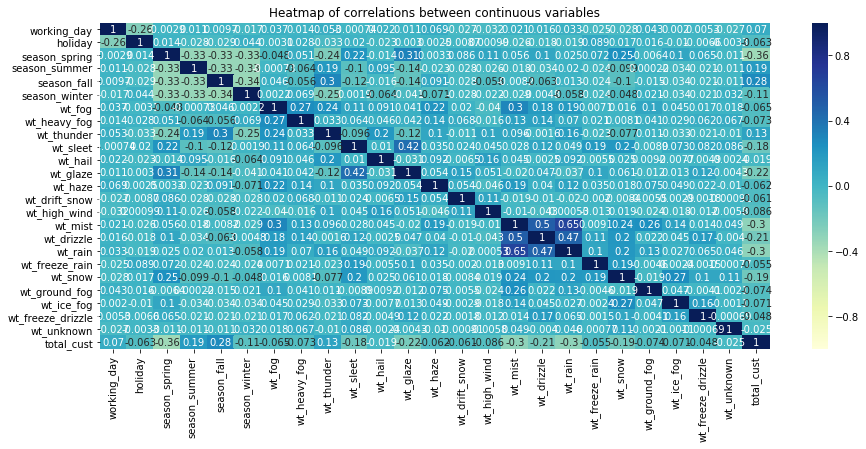

In [95]:
# create a correlation matrix
bike_df_corr_cat = bike_df.drop(columns=['date_datetime', 'weekday', 'temp_avg', 'temp_min', 'temp_max',
                                         'temp_observ', 'precip', 'wind'], axis=1)
bike_df_corr_cat = bike_df_corr_cat.corr(method='kendall')

# create a heatmap to visualize the results
plt.figure(figsize=[15,6])
sb.heatmap(bike_df_corr_cat, annot=True,
          vmin=-1, vmax=1, center=0,
          cmap='YlGnBu')
plt.title('Heatmap of correlations between continuous variables');


##### Season

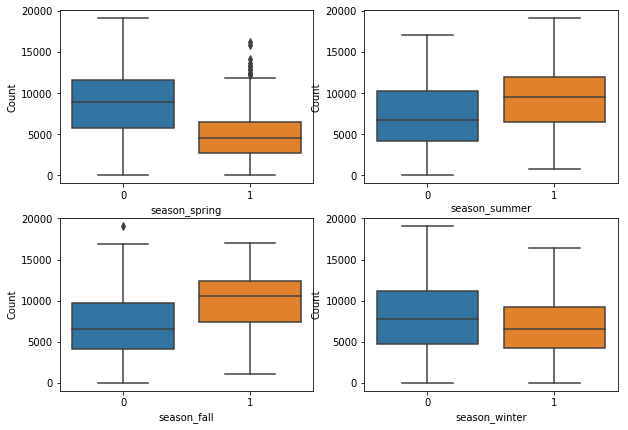

In [96]:
# variable to be used below to iterate through the columns and plot them
season_names = ['season_spring', 'season_summer', 'season_fall', 'season_winter']

# plotting the seasons vs. number of users in a boxplot
fig, ax = plt.subplots(2, 2, figsize = [10, 7])

count = 0

for j in range(len(ax)):
    for i in range(len(ax[j])):
        if j == 1 and i == 2:
            break
        else:
            ax[j][i] = sb.boxplot(data = bike_df, x = season_names[count], y = 'total_cust', ax=ax[j][i])
            ax[j][i].set_ylabel('Count')
            ax[j][i].set_xlabel(season_names[count])
            
        count += 1


The season feature clearly determines the customer demand for bikes, so this feature will be used for the final model.

##### holiday

The features holiday, weekday and workingday have some overlaps in their prediction of customer demand, thus, I will first analyze each individual feature and then investigate their correlation.

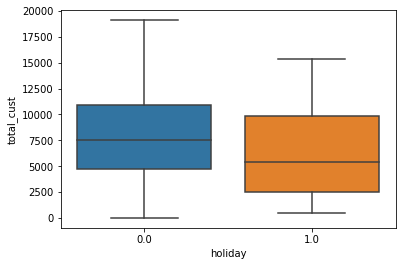

In [100]:
# plotting the customer statistics in form of a boxplot for the holiday feature
sb.boxplot(data = bike_df, x = 'holiday', y = 'total_cust');


For the holiday feature, we can clearly see that there is on average a higher demand for bikes on days that are not holidays. This feature will be used in the final model to predict the overall demand.

In [103]:
# Correlation between holiday feature and the number of customers per day
# using the Kruskal Wallis H test for correlations between a continuous and categorical variable
kruskal(bike_df['holiday'], bike_df['total_cust'])


KruskalResult(statistic=4918.648687807253, pvalue=0.0)

##### weekday

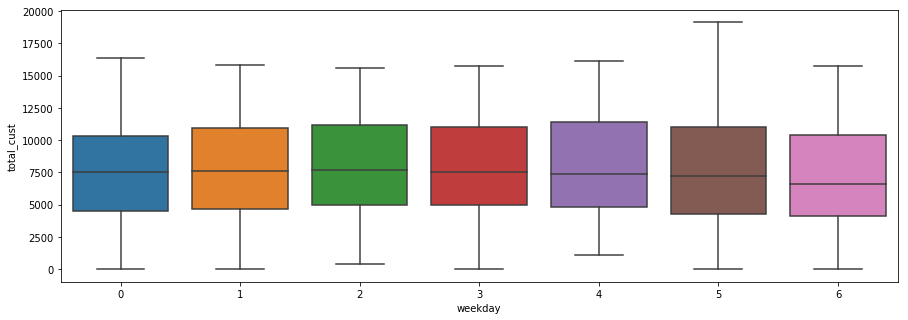

In [105]:
# plotting the customer statistics in form of a boxplot for the weekday feature
plt.figure(figsize = [15, 5])
sb.boxplot(data = bike_df, x = 'weekday', y = 'total_cust');


In [106]:
# Correlation between weekday feature and the number of customers per day
# using Pearson's correlation coefficient because I'm assuming that weekday can be 
# considered a continuous variable
pearsonr(bike_df['weekday'], bike_df['total_cust'])


(-0.024715747356080765, 0.18166202508181092)

Based on the above distributions of number of customers per weekday, it appears that there are slight difference in demand depending on what weekday it is. Thus, the weekday will be considered to forecast the bike demand.

##### workingday

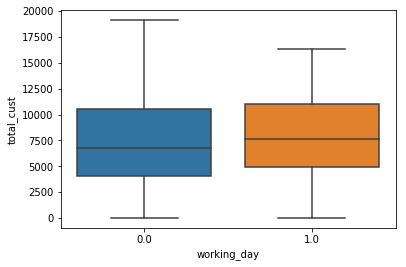

In [108]:
# plotting workday feature in boxplot against the count of customers
sb.boxplot(data = bike_df, x = 'working_day', y = 'total_cust');


In [109]:
# Correlation between working_day feature and the number of customers per day
# using the Kruskal Wallis H test for correlations between a continuous and categorical variable
kruskal(bike_df['working_day'], bike_df['total_cust'])


KruskalResult(statistic=4558.474365018898, pvalue=0.0)

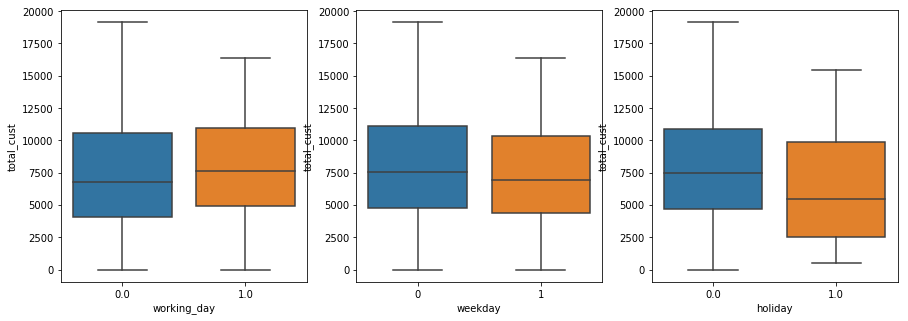

In [110]:
# create a new dataframe that encodes the weekday feature with 0 for monday through friday
# and 1 for saturday and sunday
weekend_distinct_df = bike_df.copy()
weekend_distinct_df['weekday'] = weekend_distinct_df['weekday'].apply(lambda x: 1 if (x == 6 or x == 0) else 0)

# plot boxplots for comparison between the weekday and workingday feature
plt.figure(figsize = [15, 5])

# boxplot for feature workingday
plt.subplot(1, 3, 1)
sb.boxplot(data = bike_df, x = 'working_day', y = 'total_cust');

# boxplot for feature weekday
plt.subplot(1, 3, 2)
sb.boxplot(data = weekend_distinct_df, x = 'weekday', y = 'total_cust');

# boxplot for feature holiday
plt.subplot(1, 3, 3)
sb.boxplot(data = bike_df, x = 'holiday', y = 'total_cust');


In [112]:
# plot the means of each instance of workingday
bike_df.groupby('working_day')['total_cust'].mean()


working_day
0.0    7276.939394
1.0    7918.311311
Name: total_cust, dtype: float64

In [113]:
# plot the means of each instance of weekday
weekend_distinct_df.groupby('weekday')['total_cust'].mean()


weekday
0    7875.853308
1    7315.368421
Name: total_cust, dtype: float64

In [114]:
# plot the means of each instance of holiday
bike_df.groupby('holiday')['total_cust'].mean()


holiday
0.0    7767.482174
1.0    6060.685393
Name: total_cust, dtype: float64

The features holiday, weekday and workingday are correlated with each other as well as with the target variable total_cust. However, they contain slightly different information that may be useful for predicting the target variable. Thus, I will keep all three variables for my model.

##### weather type features wt

The wt_ features contain the following features and meanings:
- wt_fog: fog, ice fog, or freezing fog (may include heavy fog)
- wt_heavy_fog: heavy fog or heaving freezing fog (not always distinguished from fog)
- wt_thunder: thunder
- wt_sleet: ice pellets, sleet, snow pellets, or small hail
- wt_hail: hail (may include small hail)
- wt_glaze: glaze or rime
- wt_haze: smoke or haze
- wt_drift_snow: blowing or drifting snow 
- wt_high_wind: high or damaging winds
- wt_mist: mist
- wt_drizzle: drizzle
- wt_rain: rain (may include freezing rain, drizzle, and freezing drizzle)
- wt_freeze_rain: freezing rain
- wt_snow: snow, snow pellets, snow grains, or ice crystals
- wt_ground_fog: ground fog
- wt_ice_fog: ice for or freezing fog
- wt_freeze_drizzle: freezing drizzle
- wt_unknown: unknown source of precipitation

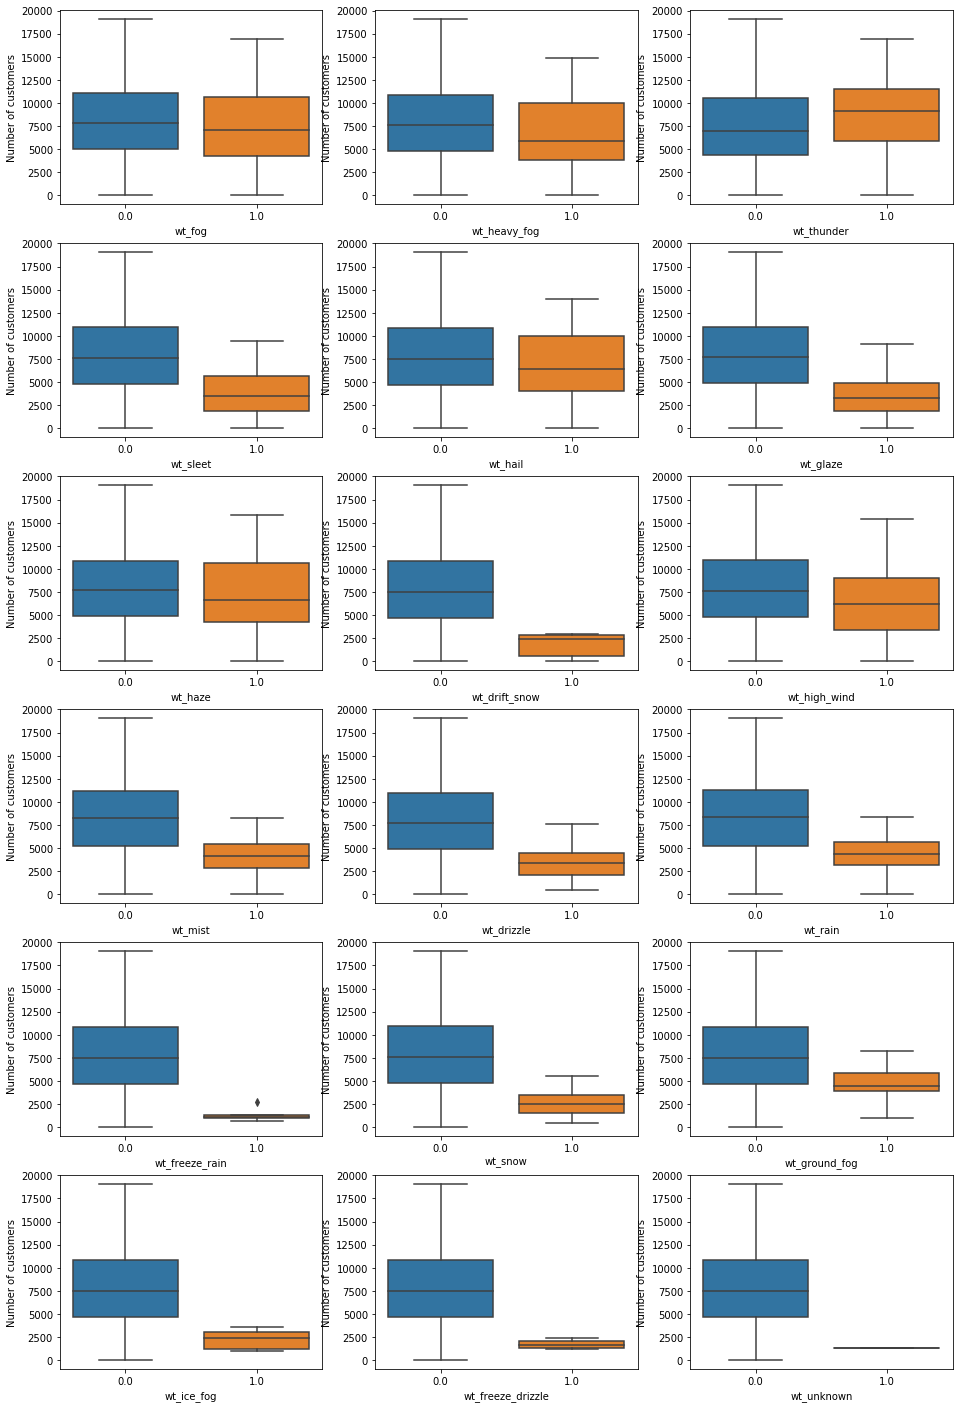

In [121]:
# plotting the revenue of the most common production companies vs. the rest
fig, ax = plt.subplots(6, 3, figsize = [16, 25])

# create list with all feature names 
wt_feat_list = [x for x in bike_df.columns if 'wt_' in x]

# company counter
counter = 0

for j in range(len(ax)):
    for i in range(len(ax[j])):
        if j == 5 and i == 3:
            break
        else:
            ax[j][i] = sb.boxplot(data = bike_df, x = wt_feat_list[counter], y = 'total_cust', ax=ax[j][i])
            ax[j][i].set_ylabel('Number of customers')
            ax[j][i].set_xlabel(wt_feat_list[counter])
            counter += 1
            

As expected, the weathersit feature has a strong influence on the number of customers. 

#### Continuous variables

granger causality
lagged data

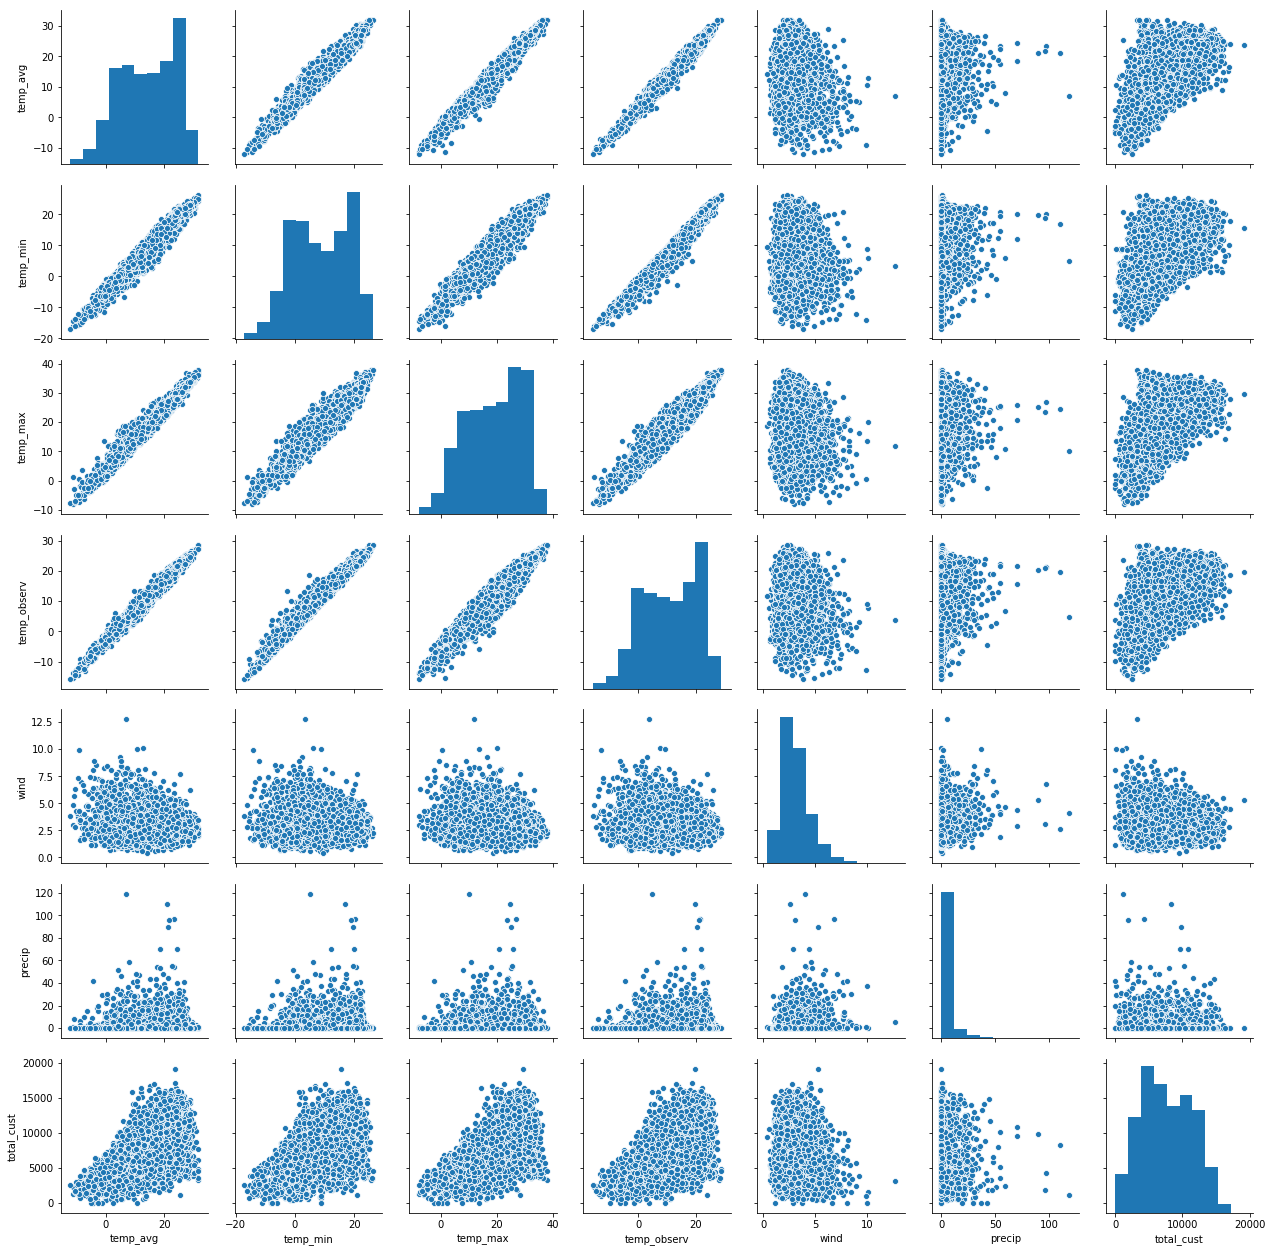

In [122]:
# plot all distributions and scatterplot between each continuous variable pair
sb.pairplot(bike_df, vars=['temp_avg', 'temp_min', 'temp_max', 'temp_observ', 'wind', 'precip', 'total_cust']);


Based on the results of the above pairplot, the following things are apparent:
* **wind looks like a Weibull distribution**
* there are almost **perfect linear relationships among the four temp features**
* **precip feature is left skewed**
* there is **no linear relationship between precip and any other feature**
* **wind** has **no linear relationship with any other feature**
* the **temp features** have a **medium strong linear relationship with the total_cust target label*



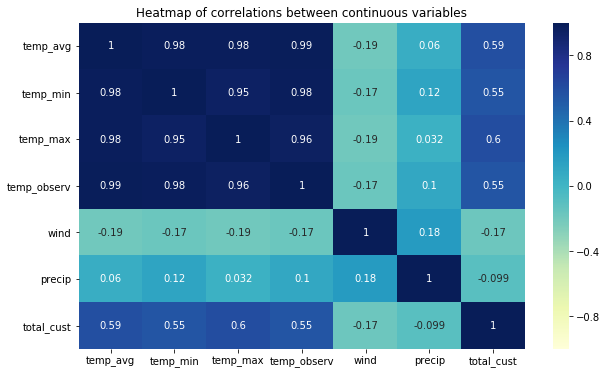

In [123]:
# create a correlation matrix
bike_df_corr = bike_df[['temp_avg', 'temp_min', 'temp_max', 'temp_observ', 'wind', 'precip', 'total_cust']].corr()

# create a heatmap to visualize the results
plt.figure(figsize=[10,6])
sb.heatmap(bike_df_corr, annot=True,
          vmin=-1, vmax=1, center=0,
          cmap='YlGnBu')
plt.title('Heatmap of correlations between continuous variables');


The heatmap underlines the indications of the pairplot and a number of steps need to be taken:
* the temp features are highly correlated with each other, thus, three of the four features need to be removed. Looking at the individual correlations with the total_cust target label, I will keep the temp_max feature.
* there are only low to very low negative correlations between wind and precip with the target label, respectively. However, I will keep both features in my model.


##### temp_max

In [140]:
# create series that group the mean temperature per season
temp_spring = bike_df.groupby('season_spring')['temp_max'].mean().rename({1: 'Spring'})
temp_summer = bike_df.groupby('season_summer')['temp_max'].mean().rename({1: 'Summer'})
temp_fall = bike_df.groupby('season_fall')['temp_max'].mean().rename({1: 'Fall'})
temp_winter = bike_df.groupby('season_winter')['temp_max'].mean().rename({1: 'Winter'})

# add them to one series and drop the rows with index 0
temp_seasons = temp_spring.append(temp_summer).append(temp_fall).append(temp_winter)
temp_seasons.drop(labels=[0], inplace=True)


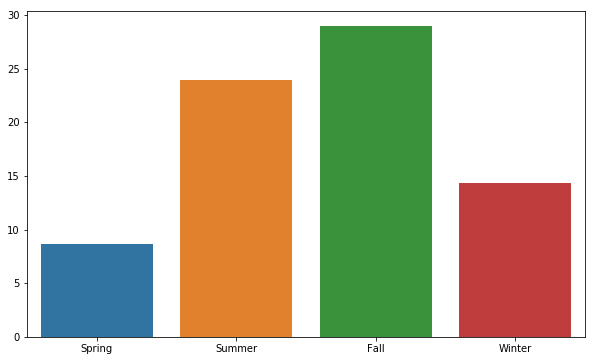

In [148]:
# plot average temp_max per season
plt.figure(figsize=[10,6])
sb.barplot(x=temp_seasons.index, y=temp_seasons.values);


In [149]:
# create series that groups average users per season
cust_spring = bike_df.groupby('season_spring')['total_cust'].mean().rename({1: 'Spring'})
cust_summer = bike_df.groupby('season_summer')['total_cust'].mean().rename({1: 'Summer'})
cust_fall = bike_df.groupby('season_fall')['total_cust'].mean().rename({1: 'Fall'})
cust_winter = bike_df.groupby('season_winter')['total_cust'].mean().rename({1: 'Winter'})

# add them to one series and drop the rows with index 0
cust_seasons = cust_spring.append(cust_summer).append(cust_fall).append(cust_winter)
cust_seasons.drop(labels=[0], inplace=True)


<Figure size 1080x504 with 0 Axes>

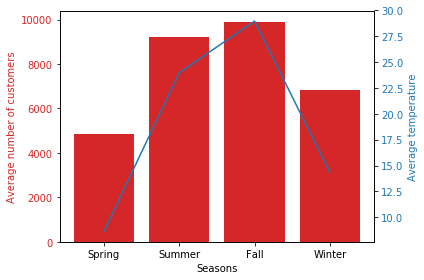

In [156]:
# assign x and y1 and y2
x = list(temp_seasons.index)
y1 = cust_seasons.values
y2 = temp_seasons.values

# below code adapted from https://matplotlib.org/gallery/api/two_scales.html
# creat plot containing both average count of customers
# and average temp per month
plt.figure(figsize=[15,7])
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color1 = 'tab:red'
ax1.set_xlabel('Seasons')
ax1.set_ylabel('Average number of customers', color=color1)
ax1.bar(x, y1, color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

color2 = 'tab:blue'
ax2.set_ylabel('Average temperature', color=color2)
ax2.plot(x, y2, color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout()
plt.show()


From the above graph we can see that the month variable is correlated with the average number of customers per that month as well as the average temperature. The temperature strongly determines the number of customers. The temperature is likely a very important feature for predicting the target variable.

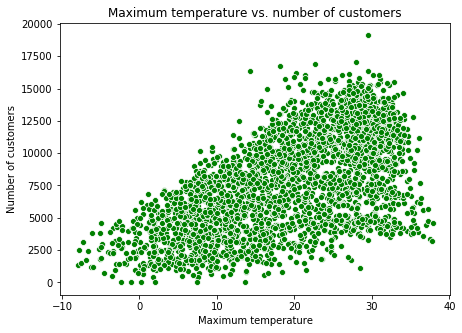

In [157]:
# plotting temp feature against the target label cnt
plt.figure(figsize=[7,5])

sb.scatterplot(data = bike_df, x = 'temp_max', y = 'total_cust', color='green')
plt.xlabel('Maximum temperature')
plt.ylabel('Number of customers')
plt.title('Maximum temperature vs. number of customers');



##### precip

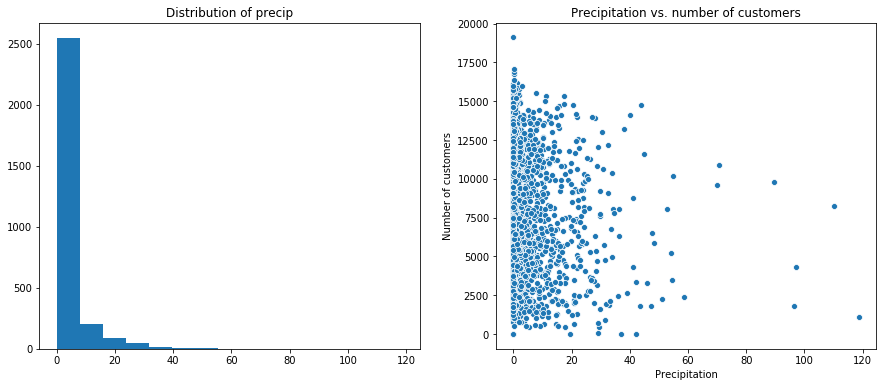

In [158]:
# plotting the distribution of precip
plt.figure(figsize=[15,6])

plt.subplot(1,2,1)
plt.hist(bike_df['precip'], bins=15)
plt.title('Distribution of precip')

plt.subplot(1,2,2)
sb.scatterplot(data = bike_df, x = 'precip', y = 'total_cust')
plt.xlabel('Precipitation')
plt.ylabel('Number of customers')
plt.title('Precipitation vs. number of customers');


Although precip is only correlated with total_cust in a weak sense, I will keep this in the model. This distribution is also left-skewed, so a logarithmic transformation will be necessary.

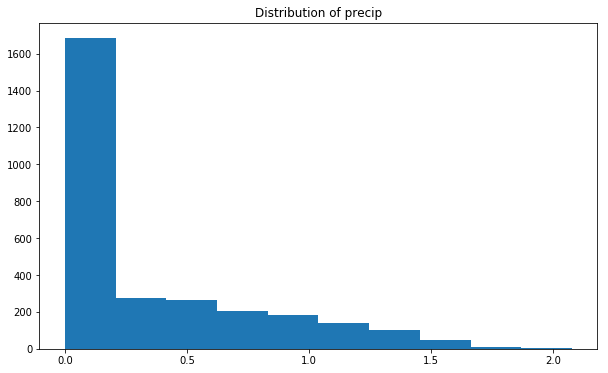

In [163]:
# plotting the distribution of precip
plt.figure(figsize=[10,6])

x = np.log10(bike_df['precip'] + 1)
plt.hist(x)
plt.title('Distribution of precip');


##### wind

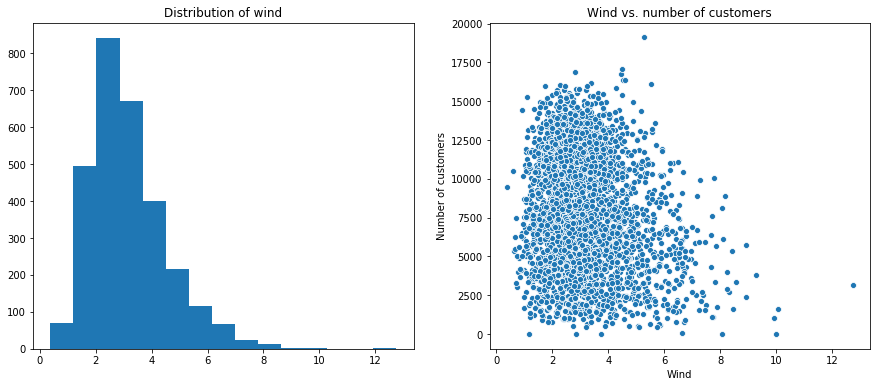

In [164]:
# plotting the distribution of wind
plt.figure(figsize=[15,6])

plt.subplot(1,2,1)
plt.hist(bike_df['wind'], bins=15)
plt.title('Distribution of wind')

plt.subplot(1,2,2)
sb.scatterplot(data = bike_df, x = 'wind', y = 'total_cust')
plt.xlabel('Wind')
plt.ylabel('Number of customers')
plt.title('Wind vs. number of customers');



Although windspeed is only correlated with cnt in a weak sense, similar to precip, I will keep this in the model.

#### 2.4. Feature Selection

It is important to avoid look ahead bias and not to consider any features or data that we can only know in the future to predict the future. Checking this bias for all features that are still in the dataset:
* holiday: no lookahead bias
* weekday: no lookahead bias
* workingday: no lookahead bias
* temp_max: temperature has lookahead bias because this is the actually realized temperature on a specific day but when we want to make forecasts, we don't know the temperature that will be realized;
* season_spring: no lookahead bias
* season_summer: no lookahead bias
* season_fall: no lookahead bias
* season_winter: no lookahead bias
* wt_ features: similar to temp_max
* wind: similar to temp_max
* precip: similar to temp_max


### 3. Data Preparation

I am creating a separate cleaning function that will take an unprocessed dataset in dataframe format and run through all the cleaning, preprocessing and data engineering steps.

In [165]:
# define cleaning function to prepare the data
def clean(df):
    '''
    Function to clean and prepare a dataset for machine learning models
    Args: df = dataframe
    Returns: X = dataframe containing features
             y = vector containing target labels
    '''    
    
    # drop features that are unnecessary for the model
    bike_df.drop(columns=['temp_avg', 'temp_min', 'temp_observ'], axis=1, inplace=True)
    
    # create season features
    
    
    # assign X and y
    y = bike_df['total_cust']
    X = bike_df.drop(columns=['total_cust'], axis=1)
    
    return X, y


In [ ]:
X, y = clean(bike_df)

In [ ]:
# should keep this before the cleaning function has been created
bike_df.drop(columns=['temp_avg', 'temp_min', 'temp_observ'], axis=1, inplace=True)



### 4. Model

Be careful --> this is time series data so I need to be careful when splitting the dataset

I may not need to split it when using pipelines, but I need to research how to do this

My pipeline should include ALL transformations, including onehot encoding, that I make after the very initial cleaning of data. Thus, I need to read in my data again after the EDA process.

If I'm using gradient descent I most DEFINITELY need to convert month and year to categorical features

my model needs to use the cnt of today and check how the weather of the previous week predicted cnt

or I could use the forecast of today and see how the forecast predicted the cnt

day 1 day 2 day 3 day 4 day 5 day 6 day 7 --> predict cnt of day 8

look at the mean and standard deviation of the 


#### 4.1. Stochastic Gradient Descent

In [171]:
bike_df.head()

,date_datetime,weekday,working_day,holiday,season_spring,season_summer,season_fall,season_winter,temp_avg,temp_min,...,wt_mist,wt_drizzle,wt_rain,wt_freeze_rain,wt_snow,wt_ground_fog,wt_ice_fog,wt_freeze_drizzle,wt_unknown,total_cust
0,2011-01-01,5,0.0,0.0,1,0,0,0,6.200000,-1.566667,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,959.0
1,2011-01-02,6,0.0,0.0,1,0,0,0,9.116667,0.880000,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,781.0
2,2011-01-03,0,1.0,0.0,1,0,0,0,1.475000,-3.442857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1301.0
3,2011-01-04,1,1.0,0.0,1,0,0,0,0.575000,-5.957143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1536.0
4,2011-01-05,2,1.0,0.0,1,0,0,0,2.383333,-4.293333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1571.0


In [168]:
# defining the hyperparameters
hyperparams = {'loss': 'log', 'penalty': 'none', 'alpha': 0.0001, 'max_iter': 1000, 
               'tol': 1e-3, 'random_state': 1909, 'eta0': 0.0001}

# initializing the model which is a Stochastic Gradient Descent model
model = SGDClassifier(**hyperparams)


In [169]:
# create ML pipeline
features_standard_scaler = [x for x in list(X.columns) if x not in ['temp_max', 'wind', 'precip']]
transformer = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('transformer', transformer, features_standard_scaler)
])

# pipeline that runs the preprocessor pipeline and then applies the model to the data set
pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('model', model)
])

# fit the data to the result of the pipeline above
pipeline = pipeline.fit(X, y)



ValueError: Unknown label type: (array([-12.1       , -11.33333333, -11.16666667, ...,  30.9       ,
        31.        ,  31.73333333]),)

#### 4.2. XGBoost

#### 4.3. AdaBoost

#### 4.4. LightGBM

### 5. Evaluation